In [95]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import shapely 
from shapely.wkt import loads as wkt_loads
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  # default='warn'


# Spatial Data and Feature Construction

## Spatial Data and Geopandas

Geopandas is a library that extends pandas to add some special capabilities for working with spatial (mapping) data. There are many functions that we can use, our primary focus will be on using spatial data to map things and to calculate features that we can use in machine learning models.

### Creating DataFrames with Geopandas

Geopandas also holds data in dataframes and most things we need to do are the same or very similar. Here, we can load some data into pandas, do some cleaning, and then convert it to a geopandas dataframe.

#### Geometry Column

One very special change to Geopandas dataframes is that they have a special column called `geometry` that holds the spatial information. This column is used by geopandas to do spatial operations and plotting. The column doesn't need to be called `geometry`, but it does need to be set as the geometry column using the `set_geometry()` function. When we ask the dataframe to "do spatial stuff" like calculate areas or plot maps, it will automatically use the geometry column to do so. 

The geometry column can hold different types of spatial data, including points, lines, and polygons. For us, we'll usually have either points (for locations) or polygons (for areas like neighborhoods).

In [96]:
area_datasets = {}
location_datasets = {}

In [97]:
#crime_data = gpd.read_file("data/nyc_spatial/NYPD_Complaint_Data_Current.csv.zip")
crime_data = pd.read_csv("data/nyc_spatial/NYPD_Complaint_Data_Current.csv.zip")
crime_data = crime_data[crime_data["Latitude"] != 0]
crime_data = crime_data[crime_data["Longitude"] != 0]
crime_data = gpd.GeoDataFrame(crime_data, geometry=gpd.points_from_xy(crime_data.Longitude, crime_data.Latitude))

### CRS

Another important concept in spatial data is the Coordinate Reference System (CRS). This is basically a way of defining how the 2D coordinates in the geometry column relate to real-world locations on the Earth's surface. Different datasets may use different CRS, so it's important to make sure that all of your spatial data is in the same CRS before doing any spatial operations. Geopandas provides functions to easily convert between different CRS.

For us, this is something that can be a bit annoying, as we need to get the CRS from the data source. However, once we have it set correctly, we can use the `to_crs()` function to convert between different CRS as needed.

#### CRS Types

Conversion between different CRS types is important because different types of spatial operations require different types of CRS. There are two main types of CRS that we will encounter:
1. **Geographic CRS**: These use latitude and longitude coordinates to define locations on the Earth's surface. They are good for storing and displaying data, but not great for measuring distances or areas because the units (degrees) are not consistent across the globe.
2. **Projected CRS**: These use a flat, 2D coordinate system to define locations. They are good for measuring distances and areas because the units (usually meters or feet) are consistent across the area being measured. However, they can distort shapes and distances, especially over large areas.

In the examples below, the data originally comes in a geographic CRS (EPSG:4326), and we can look at it and store it in that format. When I do spatial operations like measuring distances or areas, I convert it to a projected CRS (EPSG:3857) first so the measurements are accurate.

#### CRS and You

If you're only working with a limited number of spatial datasets, this problem isn't usually too bad. There's a good chance that the source of your data will provide the CRS information in the data dictionary or similar. There are also some online and programmatic tools to help identify the CRS if it's not provided. 

Overall, if you're just dealing with one or two datasets, you can check to ensure that what you're doing works by doing something like selecting a couple of specifics and checking the results manually. It is worth the time at the front end to deal with this, it'll make everything else work kind of magically later on. 

In [98]:

crime_data.set_crs(epsg=4326, inplace=True)
crime_data = crime_data.set_geometry(gpd.points_from_xy(crime_data.Longitude, crime_data.Latitude))
location_datasets['crime'] = crime_data
crime_data.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Latitude,Longitude,Lat_Lon,New Georeferenced Column,geometry
0,303250435,13,MANHATTAN,03/20/2025,00:30:00,NaN,(null),COMPLETED,(null),NaN,...,M,NaN,25-44,WHITE,M,40.737203,-73.983273,"(40.7372030985741, -73.9832725981497)",POINT (-73.9832725981497 40.7372030985741),POINT (-73.98327 40.73720)
1,298788022,81,BROOKLYN,01/02/2025,01:50:00,01/02/2025,03:00:00,COMPLETED,(null),NaN,...,M,NaN,18-24,WHITE,F,40.689464,-73.924029,"(40.6894642952604, -73.9240290899499)",POINT (-73.9240290899499 40.6894642952604),POINT (-73.92403 40.68946)
2,307271594,47,BRONX,03/05/2025,17:00:00,NaN,(null),COMPLETED,(null),NaN,...,M,NaN,25-44,BLACK,F,40.887314,-73.847272,"(40.8873136344706, -73.8472717577564)",POINT (-73.8472717577564 40.8873136344706),POINT (-73.84727 40.88731)
8,313240502,121,STATEN ISLAND,09/17/2025,18:00:00,09/17/2025,18:10:00,COMPLETED,(null),NaN,...,M,NaN,UNKNOWN,UNKNOWN,D,40.626245,-74.175157,"(40.626245, -74.175157)",POINT (-74.175157 40.626245),POINT (-74.17516 40.62624)
9,304170874,120,STATEN ISLAND,04/03/2025,15:32:00,04/03/2025,16:16:00,COMPLETED,(null),NaN,...,M,NaN,45-64,ASIAN / PACIFIC ISLANDER,M,40.634128,-74.122504,"(40.634128, -74.122504)",POINT (-74.122504 40.634128),POINT (-74.12250 40.63413)


### Directly Reading into Geopandas

Geopandas can read in data directly using the `gpd.read_file()` function. This function can read standard CSV data that has spatial information, but it can also read in shapefiles, GeoJSON files, and other common spatial data formats.

#### From WKT/WKB

There's another example here of loading data from WKT (Well-Known Text) or WKB (Well-Known Binary) formats. These are standard formats for representing spatial data as text or binary strings. Geopandas can read these formats directly into the geometry column using the `gpd.GeoSeries.from_wkt()` or `gpd.GeoSeries.from_wkb()` functions. The details of this are not really relevant to us, but basically these functions convert the text or binary strings into geometry objects that Geopandas can use. If you find that you have data that Geopandas rejects when being read directly, this is a common solution. 

#### Geopandas Reading Annoyances

Sometimes, Geopandas can be a bit finicky about reading in data. The geometry column might not be readable or recognized correctly. In such cases, we can almost always find some workaround - the data we need is some latitude/longitude or some regions defined by polygons, so we can usually reconstruct the geometry column manually if needed.

### Neighborhoods

In [99]:
hoods = gpd.read_file('data/nyc_spatial/Neighborhoods.csv')
hoods_series = gpd.GeoSeries.from_wkt(hoods['the_geom'])
hoods["geometry"] = hoods_series
hoods = hoods.drop(columns=['the_geom'])
hoods = hoods.set_geometry('geometry')
hoods.set_crs(epsg=4326, inplace=True)
area_datasets['neighborhoods'] = hoods
hoods.head()

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Length,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),"28,919.5611508","35,321,808.3909","MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),"28,134.0826611","28,852,852.9133","MULTIPOLYGON (((-73.95814 40.72440, -73.95772 ..."
2,3,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),"18,250.2800908","15,208,960.645","MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ..."
3,3,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),"43,184.8003755","52,267,406.735","MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ..."
4,3,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,"14,312.1922849","9,982,022.78755","MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ..."


### Bathrooms

In [100]:
bathroom_locations = gpd.read_file('data/nyc_spatial/Public_Restrooms.csv')
bathroom_locations.set_crs(epsg=4326, inplace=True)
bathroom_locations = bathroom_locations.set_geometry(gpd.points_from_xy(bathroom_locations.Longitude, bathroom_locations.Latitude))
location_datasets['bathrooms'] = bathroom_locations
bathroom_locations.head()

,Facility Name,Location Type,Operator,Status,Open,Hours of Operation,Accessibility,Restroom Type,Changing Stations,Additional Notes,Website,Latitude,Longitude,Location,geometry
0,Battery Park Zone 1,Park,NYC Parks,Not Operational,,,,,Yes,,,40.70441,-74.0159,POINT (-74.0159 40.70441),POINT (-74.01590 40.70441)
1,Carl Schurz Main Lawn,Park,NYC Parks,Not Operational,,,Partially Accessible,Multi-Stall W/M Restrooms,Yes,,,40.77358,-73.945,POINT (-73.945 40.77358),POINT (-73.94500 40.77358)
2,Tappen Park,Park,NYC Parks,Not Operational,,,,,"""N/A, restrooms closed""",,,40.62661,-74.0778,POINT (-74.0778 40.62661),POINT (-74.07780 40.62661)
3,Refinery Building,Park,Domino Park,Operational,Year Round,6am-11pm,,,,,,40.714424,-73.967306,POINT (-73.967306 40.714424),POINT (-73.96731 40.71442)
4,"Gravesend Library, BPL",Library,BPL,Closed for Construction,Year Round,,Fully Accessible,Single-Stall All Gender Restroom(s),Yes,,https://www.bklynlibrary.org/locations/gravesend,40.590553,-73.97181,POINT (-73.97181 40.590553),POINT (-73.97181 40.59055)


### Parks

In [101]:
parks = gpd.read_file('data/nyc_spatial/nyc_parks.csv')
parks_series = gpd.GeoSeries.from_wkt(parks['multipolygon'])
parks["geometry"] = parks_series
parks = parks.drop(columns=['multipolygon'])
parks = parks.set_geometry('geometry')
parks.set_crs(epsg=4326, inplace=True)
area_datasets['parks'] = parks
parks.head()

,ACQUISITIONDATE,ACRES,ADDRESS,BOROUGH,CLASS,COMMUNITYBOARD,COUNCILDISTRICT,DEPARTMENT,GISOBJID,GISPROPNUM,...,PIP_RATABLE,PRECINCT,RETIRED,SIGNNAME,SUBCATEGORY,TYPECATEGORY,US_CONGRESS,WATERFRONT,ZIPCODE,geometry
0,1972 Sep 22 12:00:00 AM,83.3,1000 RICHMOND TERRACE,R,PARK,501,49,R-01,"100,003,741",R116,...,false,120,false,Snug Harbor Cultural Center,Large Park,Historic House Park,11,true,"10301, 10310","MULTIPOLYGON (((-74.10087 40.64469, -74.10089 ..."
1,1934 Feb 28 12:00:00 AM,0.403,532 EAST 12 STREET,M,PARK,103,2,M-03,"100,004,130",M113,...,true,9,false,Joseph C. Sauer Park,Neighborhood Plgd,Neighborhood Park,10,false,10009,"MULTIPOLYGON (((-73.97938 40.72812, -73.97934 ..."
2,1934 Jun 08 12:00:00 AM,0.763,2 2 AVENUE,M,PARK,103,2,M-03,"100,004,795",M124,...,true,9,false,First Park,Neighborhood Plgd,Neighborhood Park,10,false,10003,"MULTIPOLYGON (((-73.99042 40.72402, -73.99052 ..."
3,1926 Apr 29 12:00:00 AM,286.557,298 SATERLEE STREET,R,PARK,503,51,R-03,"100,004,319",R006,...,false,123,false,Conference House Park,Large Park,Nature Area,11,true,"10307, 10309","MULTIPOLYGON (((-74.25204 40.50292, -74.25244 ..."
4,1948 Jan 29 12:00:00 AM,1.534,255 PARKINSON AVENUE,R,PARK,502,50,R-02B,"100,004,659",R063,...,true,122,false,Old Town Playground,JOP,Playground,11,false,10305,"MULTIPOLYGON (((-74.08083 40.59514, -74.08076 ..."


### High Schools

In [102]:
schools = gpd.read_file('data/nyc_spatial/nyc_high_schools.csv')
schools = schools.set_geometry(gpd.points_from_xy(schools.Longitude, schools.Latitude))
schools.set_crs(epsg=4326, inplace=True)
schools = gpd.GeoDataFrame(schools, geometry=schools.geometry)
location_datasets['high_schools'] = schools
schools.head()

,dbn,school_name,boro,overview_paragraph,school_10th_seats,academicopportunities1,academicopportunities2,academicopportunities3,academicopportunities4,academicopportunities5,...,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,geometry
0,16K498,Brooklyn High School for Law and Technology,K,The mission of Brooklyn High School for Law an...,Y,iLearnNYC: Program for expanded online coursew...,Access to Law and Technology Programs: Youth C...,"Computer Programming, iCareers, Online courses...","Multicultural Literature, Conflict Resolution/...",,...,BROOKLYN,40.688831,-73.920906,3,41,375,"3,039,676","3,014,820,001",Stuyvesant Heights ...,POINT (-73.92091 40.68883)
1,17K524,International High School at Prospect Heights,K,We are a small school that works in teams to p...,Y,"We are a Performance-Based Assessment school, ...","Safe, supportive, and nurturing environment wh...",We are a Computer Science for All school. Thro...,All students are matched to an internship in t...,"Afterschool programs include: Peer Tutoring, A...",...,BROOKLYN,40.670349,-73.961695,9,35,213,"3,029,686","3,011,870,001",Crown Heights South ...,POINT (-73.96170 40.67035)
2,02M531,Repertory Company High School for Theatre Arts,M,We offer a college-preparatory program and New...,Y,iLearnNYC: Program for expanded online coursew...,"Advisory, Acting, Playwriting, Stagecraft, Mus...","National Honor Society, yearly grade-level res...",Learning Through Expanded Arts Playwriting Pro...,"Roundabout Theatre Company (Playwriting, IATSE...",...,MANHATTAN,40.755843,-73.984382,5,4,119,"1,022,615","1,009,960,021",Midtown-Midtown South ...,POINT (-73.98438 40.75584)
3,05M670,Thurgood Marshall Academy for Learning and Soc...,M,Thurgood Marshall Academy is an academically r...,Y,We offer a Regents curriculum designed to grad...,"Enrichment: Early College High School Program,...",College and Career Readiness: On-site College ...,Community Service and Internship: Abyssinian D...,"Partnerships: Columbia University, Northside C...",...,MANHATTAN,40.815509,-73.944202,10,9,228,"1,058,843","1,019,400,035",Central Harlem North-Polo Grounds ...,POINT (-73.94420 40.81551)
4,15K423,Brooklyn Frontiers High School,K,Brooklyn Frontiers High School serves entering...,,Partnership with Good Shepherd Services: coach...,"Small classes, many co-taught by two teachers","Many opportunities for tutoring and support, b...",Paid Learning to Work Internships,,...,BROOKLYN,40.690145,-73.989132,2,33,43,"3,000,533","3,001,690,009",DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hi...,POINT (-73.98913 40.69015)


### WiFi

In [103]:
wifi = gpd.read_file('data/nyc_spatial/nyc_wifi.csv')
wifi = wifi.set_geometry(gpd.points_from_xy(wifi.Longitude, wifi.Latitude))
wifi.set_crs(epsg=4326, inplace=True)
location_datasets['wifi'] = wifi
wifi.head()

,OBJECTID,Borough,Type,Provider,Name,Location,Latitude,Longitude,X,Y,...,Council Distrcit,Postcode,BoroCD,Census Tract,BCTCB2010,BIN,BBL,DOITT_ID,"Location (Lat, Long)",geometry
0,10604,4,Limited Free,SPECTRUM,Baisley Pond Park,Park Perimeter,40.6748599999,-73.7841200005,"1,044,131.89696","185,219.892077",...,28,11434,412,294,294,0,0,1408,"(40.6748599999, -73.7841200005)",POINT (-73.78412 40.67486)
1,10555,4,Limited Free,SPECTRUM,Kissena Park,Park Perimeter,40.7475599996,-73.8181499997,"1,034,637.51076","211,685.217755",...,20,11355,407,845,845,0,0,1359,"(40.7475599996, -73.8181499997)",POINT (-73.81815 40.74756)
2,12370,3,Free,Transit Wireless,Grand St (L),Grand St (L),40.7119259997,-73.9406699994,"1,000,698.12752","198,655.90884",...,34,11206,301,495,495,0,0,1699,"(40.7119259997, -73.9406699994)",POINT (-73.94067 40.71193)
3,9893,3,Free,Downtown Brooklyn,,125 Court St.,40.6899850001,-73.9919950004,"986,469.966349","190,656.680416",...,33,11201,302,9,9,3388736,3002777501,298,"(40.6899850001, -73.9919950004)",POINT (-73.99200 40.68999)
4,10169,1,Free,Transit Wireless,Lexington Av-63 St (F),Lexington Av-63 St (F),40.7646300002,-73.9661150001,"993,636.552081","217,853.888161",...,4,10065,108,120,120,0,0,599,"(40.7646300002, -73.9661150001)",POINT (-73.96612 40.76463)


### Bus Stops

In [104]:
bus_stops = gpd.read_file('data/nyc_spatial/nyc_bus_stops.csv')
bus_stops = bus_stops.set_geometry(gpd.points_from_xy(bus_stops.Longitude, bus_stops.Latitude))
bus_stops.set_crs(epsg=4326, inplace=True)
location_datasets['bus_stops'] = bus_stops
bus_stops.head()

,the_geom,BoroCode,BoroName,BoroCD,CounDist,AssemDist,StSenDist,CongDist,Shelter_ID,Corner,On_Street,Cross_Stre,Longitude,Latitude,NTAName,FEMAFldz,FEMAFldT,HrcEvac,geometry
0,POINT (-73.947831 40.706812),3,Brooklyn,301,34,53,18,7,BR0003,SE,MONTROSE AV,LORIMER ST,-73.947831,40.706812,East Williamsburg,X,AREA OF MINIMAL FLOOD HAZARD,4,POINT (-73.94783 40.70681)
1,POINT (-73.945162 40.719097),3,Brooklyn,301,34,50,18,7,BR0014,NE,GRAHAM AV,HERBERT ST,-73.945162,40.719097,East Williamsburg,X,AREA OF MINIMAL FLOOD HAZARD,4,POINT (-73.94516 40.71910)
2,POINT (-73.945783 40.702976),3,Brooklyn,301,34,53,18,7,BR0026,NE,BROADWAY,LEONARD ST,-73.945783,40.702976,East Williamsburg,X,AREA OF MINIMAL FLOOD HAZARD,3,POINT (-73.94578 40.70298)
3,POINT (-73.940836 40.720195),3,Brooklyn,301,34,50,18,7,BR0028,SW,KINGSLAND AV,HERBERT ST,-73.940836,40.720195,East Williamsburg,X,AREA OF MINIMAL FLOOD HAZARD,6,POINT (-73.94084 40.72019)
4,POINT (-73.969795 40.69344),3,Brooklyn,302,35,57,25,7,BR0040,NE,VANDERBILT AV,MYRTLE AV,-73.969795,40.69344,Fort Greene,X,AREA OF MINIMAL FLOOD HAZARD,X,POINT (-73.96980 40.69344)


### NYC Shapefile

This is a shapefile that contains the boundaries of various administrative areas in NYC. We'll use it basically as the base map for plotting other data on top of it.

In [105]:
nyc_shapefile = gpd.read_file('data/nyc_spatial/nyc_shapefile.zip')
nyc_shapefile.to_crs(epsg=4326, inplace=True)

## Using Spatial Data

### Visualizing Spatial Data

We can map or visualize spatial data easily using Geopandas. The plot() function works similarly to pandas, but it uses the geometry column to create maps. We can also use the `explore()` function to create interactive maps using Folium.

When plotting we can layer multiple datasets on the same map, customize colors and styles, and add legends and titles. To do this, we can use matplotlib functions to create a figure and axis, and then plot each dataset on the same axis. Adding some parameters to the plot function to control colors, transparency, and legends can help make the map more informative.

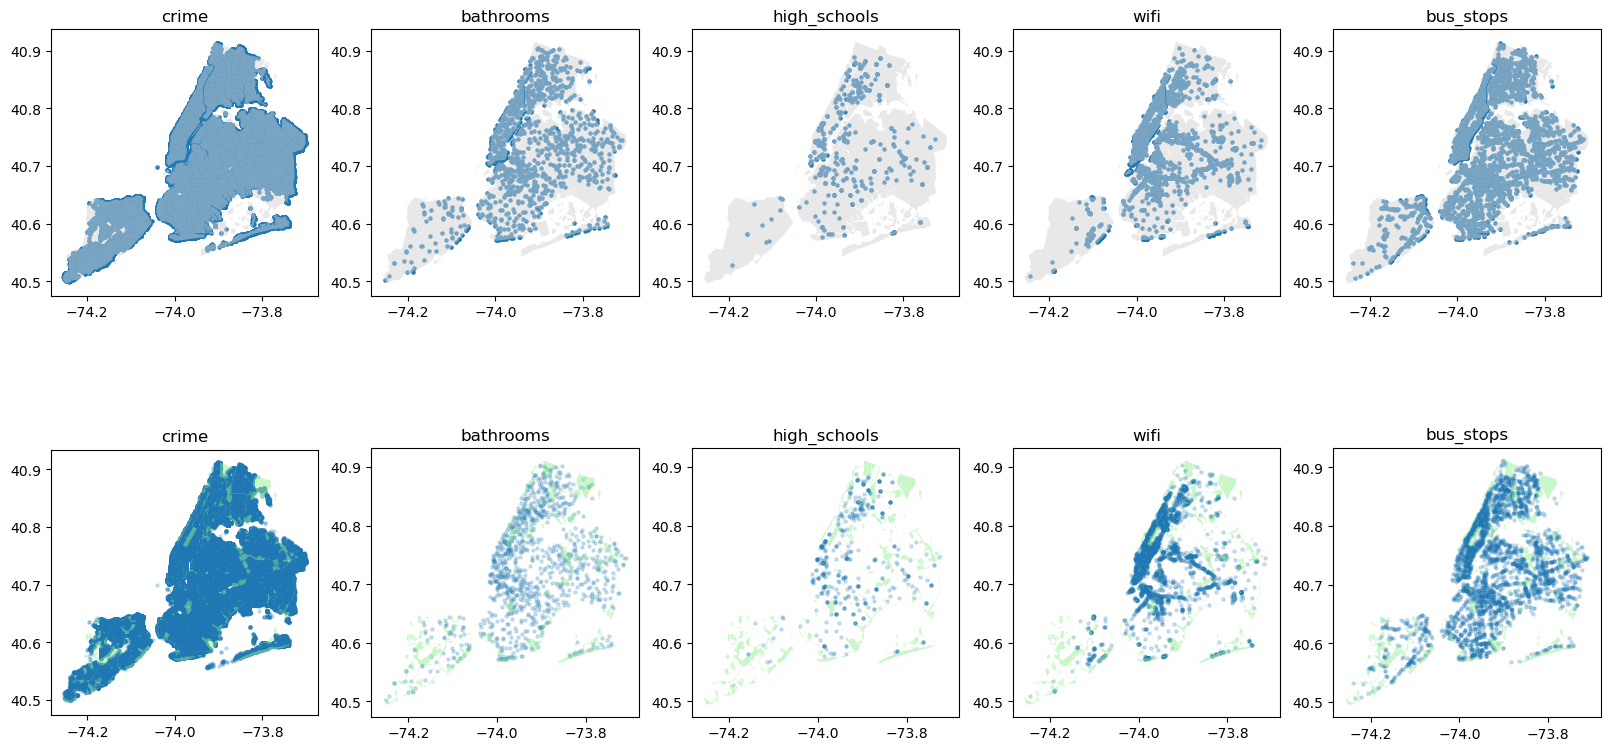

<Figure size 640x480 with 0 Axes>

In [106]:
num_datasets = len(location_datasets)
fig, ax = plt.subplots( 2, num_datasets , figsize=(20,10) )

for i, (name, dataset) in enumerate(location_datasets.items()):
    ax[0,i].set_title(name)
    dataset.plot(ax=ax[0,i], markersize=5)
    hoods.plot(ax=ax[0,i], color='lightgrey', alpha=0.5)
    #nyc_shapefile.plot(ax=ax[0,i], color='lightgrey', alpha=0.5)
    ax[1,i].set_title(name)
    dataset.plot(ax=ax[1,i], markersize=5, alpha=0.2)
    parks.plot(ax=ax[1,i], color='lightgreen', alpha=0.5)
plt.show()
plt.tight_layout()

In [107]:
#schools.explore()
#crime_data.explore()

### Spatial Functions and Calculations

We can calculate various spatial features using Geopandas. Some common spatial calculations include:
<ul>
<li>Calculating distances.</li>
<li>Calculating areas and perimeters.</li>
<li>Finding centroids of polygons.</li>
<li>Buffering geometries (creating a zone around a point or polygon).</li>
<li>Spatial joins (joining two datasets based on their spatial relationship).</li>
</ul>

Calculations are automatically done using the geometry column and a (usually simple) call to one of the built-in functions. For example, to calculate the area of each polygon in a dataframe, we can simply call the `area` attribute on the geometry column.

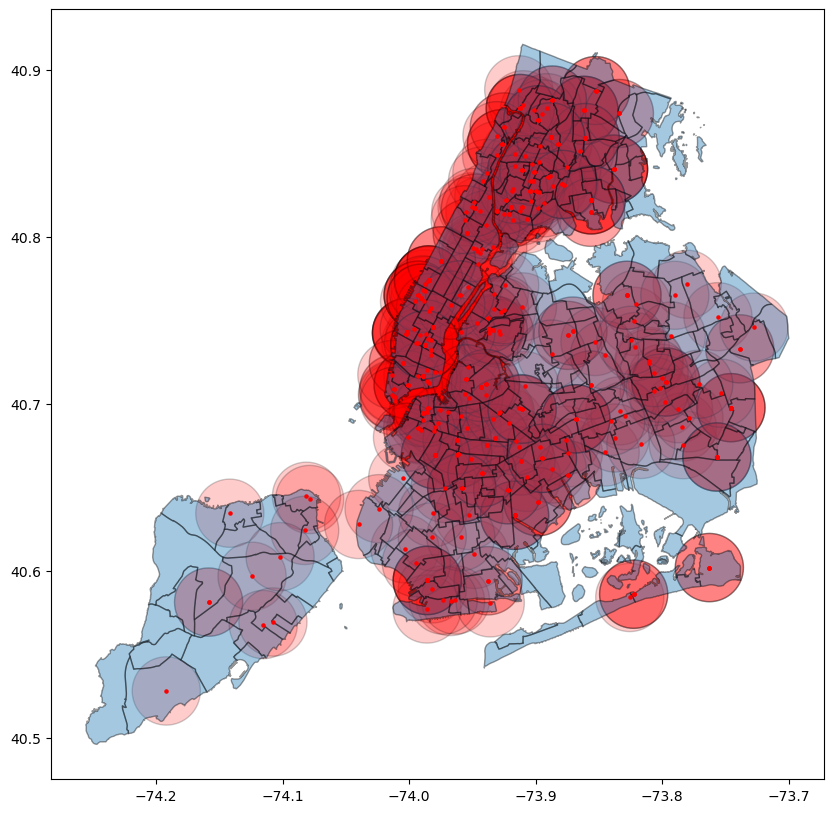

In [108]:
buffer_distance = 3000  # buffer distance in meters
#crime_data = crime_data.to_crs(epsg=3857)
#schools = schools.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10,10))
schools_2 = schools.to_crs(epsg=3857)
schools_2["buffered_geometry"] = schools_2.buffer(buffer_distance)
schools_2.set_geometry("buffered_geometry", inplace=True)
schools_2.to_crs(epsg=4326, inplace=True)
schools_2.plot(alpha=0.2, figsize=(10,10), ax=ax, color="red", edgecolor='k')
#hoods.to_crs(epsg=3857).plot(ax=ax, alpha=0.4, edgecolor='k')
hoods.plot(ax=ax, alpha=0.4, edgecolor='k')
schools.plot(ax=ax, color='red', markersize=5)
plt.show()

### Distance Calculations

We can calculate the distance between points or between spatial objects using the `distance()` function. As long as both datasets have geometry columns and are in the same CRS, we can calculate distances easily.

#### Distance - Closest Bus Stop to School

We can add a column to a schools dataframe that contains the distance to the closest bus stop. This is done by iterating over each school, calculating the distance to all bus stops, and then finding the minimum distance.

In [109]:
def calculateNearest(location, list_of_locations):
    nearest_distance = list_of_locations.geometry.distance(location.geometry).min()
    return nearest_distance

schools["nearest_bus_stop_distance"] = schools.to_crs(epsg=3857).apply(lambda x: calculateNearest(x, bus_stops.to_crs(epsg=3857)), axis=1)
schools[["school_name", "nearest_bus_stop_distance"]].head()

,school_name,nearest_bus_stop_distance
0,Brooklyn High School for Law and Technology,333.568065
1,International High School at Prospect Heights,75.147675
2,Repertory Company High School for Theatre Arts,138.996662
3,Thurgood Marshall Academy for Learning and Soc...,59.101713
4,Brooklyn Frontiers High School,63.929350


### Spatial Joins

One of the most powerful features of Geopandas is the ability to do spatial joins. A spatial join is similar to a regular join in pandas, but instead of joining on a common column, we join based on the spatial relationship between the geometries in the two dataframes. For example, we can join a dataframe of crime incidents (points) with a dataframe of neighborhoods (polygons) to find out which neighborhood each crime incident occurred in.

In [110]:
#hoods.to_crs(epsg=3857, inplace=True)
#crimes_with_hoods = gpd.sjoin(crime_data.to_crs(epsg=3857), hoods.to_crs(epsg=3857), how='left', predicate='within')
crimes_with_hoods = gpd.sjoin(crime_data, hoods, how='left', predicate='within')
crimes_with_hoods.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Length,Shape_Area
0,303250435,13,MANHATTAN,03/20/2025,00:30:00,NaN,(null),COMPLETED,(null),NaN,...,Manhattan,061,MN0602,Gramercy,Grmrcy,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,"12,095.3773915","7,526,022.78361"
1,298788022,81,BROOKLYN,01/02/2025,01:50:00,01/02/2025,03:00:00,COMPLETED,(null),NaN,...,Brooklyn,047,BK0302,Bedford-Stuyvesant (East),BdSty_E,0,BK03,BK03 Bedford-Stuyvesant (CD 3 Approximation),"29,753.9705547","41,289,700.8748"
2,307271594,47,BRONX,03/05/2025,17:00:00,NaN,(null),COMPLETED,(null),NaN,...,Bronx,005,BX1203,Wakefield-Woodlawn,Wkfld_Wdln,0,BX12,BX12 Wakefield-Williamsbridge-Eastchester (CD ...,"39,101.7261167","39,646,811.0794"
8,313240502,121,STATEN ISLAND,09/17/2025,18:00:00,09/17/2025,18:10:00,COMPLETED,(null),NaN,...,Staten Island,085,SI0107,Mariner's Harbor-Arlington-Graniteville,MrnrsHrbr,0,SI01,SI01 North Shore (CD 1 Equivalent),"71,332.7003512","89,389,405.913"
9,304170874,120,STATEN ISLAND,04/03/2025,15:32:00,04/03/2025,16:16:00,COMPLETED,(null),NaN,...,Staten Island,085,SI0106,Port Richmond,PrtRchmnd,0,SI01,SI01 North Shore (CD 1 Equivalent),"39,708.1608207","36,236,920.9342"


In [111]:
crimes_with_hoods['NTAName'].value_counts().head(10)

NTAName
Midtown-Times Square                   9582
Jamaica                                7048
Mott Haven-Port Morris                 6063
Melrose                                5762
East Harlem (North)                    5683
Harlem (North)                         5584
Concourse-Concourse Village            5547
Hell's Kitchen                         5539
Bedford-Stuyvesant (East)              5301
Midtown South-Flatiron-Union Square    5252
Name: count, dtype: int64

## Making Predictions with Spatial Data

## Generating Features

Another big thing that we can do with spatial data is to generate features for machine learning models. Geographical data often has useful information in it for many situations, but the latitude and longitude coordinates themselves are not very useful as features. However, we can use the spatial data, potentially combined with other datasets, to generate features that can be used in models. Some common examples include:
<ul>
<li> Distance to important locations (e.g., parks, schools, public transit)</li>
<li> Density of certain features in the surrounding area (e.g., number of parks within a certain radius)</li>
<li> Counting occurrences within certain areas (e.g., number of crimes in the neighborhood)</li>
</ul>
These features can often provide valuable information to machine learning models and improve their performance.

### Feature Construction

There are many ways to construct features from spatial data. Some common techniques include:
<ul>
<li> Buffering: Creating a buffer zone around a point or polygon to analyze the surrounding area</li>
<li> Spatial Aggregation: Summarizing data within certain areas (e.g., counting occurrences within neighborhoods)</li>
<li> Distance Calculations: Calculating distances between points and important locations</li>
</ul>

Each of these will be a pretty scenario specific thing, we want to think of "what is useful for my problem?" and then figure out how to calculate that using the spatial data we have. Some domain knowledge is needed here to do a really good job.

In [112]:
def countWithinBuffer(locations_to_count, locations_to_buffer, buffer_distance):
    """
    Count the number of items from locations_to_count that fall within 
    a buffer distance of each item in locations_to_buffer.
    
    Parameters:
    -----------
    locations_to_count : GeoDataFrame
        GeoDataFrame containing points to be counted
    locations_to_buffer : GeoDataFrame or GeoSeries
        GeoDataFrame or geometry to create buffer around
    buffer_distance : float
        Buffer distance in meters
    
    Returns:
    --------
    int or Series
        Count of items within the buffer
    """
    # Convert to projected CRS for accurate distance calculations
    locations_to_count_proj = locations_to_count.to_crs(epsg=3857)
    locations_to_buffer_proj = locations_to_buffer.to_crs(epsg=3857)
    
    # Create buffer around the location(s)
    buffered_geometry = locations_to_buffer_proj.geometry.buffer(buffer_distance)
    
    # Count how many points fall within the buffer
    counts = []
    for item in buffered_geometry:
        count = locations_to_count_proj.within(item).sum()
        counts.append(count)
    
    return counts

### Target - Graduation Rate

We'll predict the graduation rate of high schools in NYC using mostly things we've constructed from spatial data. We probably shouldn't expect this model to be great, these features are mostly just for the sake of demonstration. 

<b>Note:</b> If this data was from some city other than NYC, I suspect our model may do better with the same information. In many places, spatial features like proximity to parks, public transit, and neighborhood characteristics like parks are massively correlated with wealth, which is by far the most important factor in academic funding and performance. NYC is one of the few places in the USA where things are dense enough that the rich and poor can somewhat overlap. 

In [113]:
schools = schools[schools["graduation_rate"] != 'N/A']
schools["graduation_rate"] = schools["graduation_rate"].astype(float, errors='ignore')

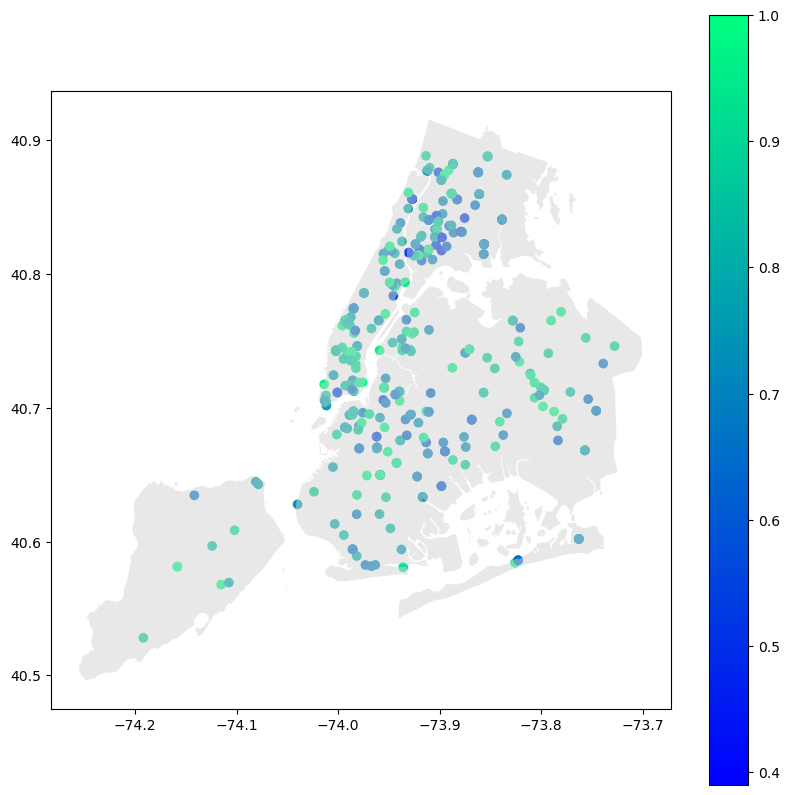

In [114]:
fig, ax = plt.subplots(figsize=(10,10))
schools.plot(ax=ax, column='graduation_rate', legend=True, cmap='winter')
hoods.plot(ax=ax, color='lightgrey', alpha=0.5)
plt.show()

### Adding Features

We'll add some features that may be useful for predicting various things. These examples are just illustrative, each scenario will be different and require different features to be constructed in different ways. Distance, intersections, counts, and densities are all common things to consider as potentially useful features.

We may also need to use groupby operations to aggregate data at different levels (e.g., neighborhood level instead of point level).

In [115]:
try:
    schools["total_students"] = schools["total_students"].str.replace(',', '')
except:
    schools["total_students"] = schools["total_students"].replace(',', '')
    
schools["total_students"] = schools["total_students"].replace('N/A', 0).astype(int, errors='ignore')
schools["college_career_rate"] = schools["college_career_rate"].replace('N/A', 0).astype(float)

# Create Features
schools["wifi_count"] = countWithinBuffer(wifi, schools, buffer_distance)
schools["public_restroom_count"] = countWithinBuffer(bathroom_locations, schools, buffer_distance)
schools["bus_stop_count"] = countWithinBuffer(bus_stops, schools, buffer_distance)
schools["closest_park_distance"] = schools.to_crs(epsg=3857).apply(lambda x: calculateNearest(x, parks.to_crs(epsg=3857)), axis=1)

numeric_features = ["graduation_rate", "college_career_rate", "wifi_count", 
                    "public_restroom_count", "bus_stop_count", "closest_park_distance", 
                    "total_students",]

#categorical_features = ["boro", "shared_space"]
categorical_features = ["shared_space"]

#Force types
for feature in numeric_features:
    schools[feature] = pd.to_numeric(schools[feature], errors='coerce')

for feature in categorical_features:
    schools[feature] = schools[feature].astype('category')

school_features = numeric_features + categorical_features

schools_subset = schools[school_features]
schools_subset.head()

,graduation_rate,college_career_rate,wifi_count,public_restroom_count,bus_stop_count,closest_park_distance,total_students,shared_space
0,0.74,0.49,63,36,124,169.513034,594,No
1,0.63,0.53,151,42,132,16.215474,417,Yes
2,0.96,0.87,648,62,199,180.885218,242,No
3,0.81,0.60,410,56,208,64.912597,547,No
6,0.99,0.94,118,20,83,737.697505,623,Yes


/Users/akeem/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='graduation_rate', ylabel='Density'>

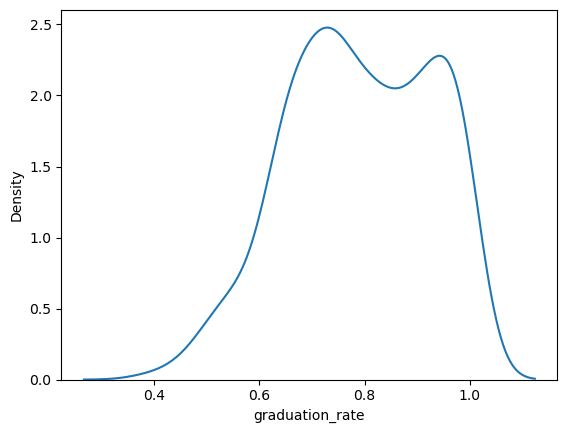

In [116]:
sns.kdeplot(data=schools_subset, x="graduation_rate")

In [117]:
# Regular join on neighborhood name
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

schools_data = schools_subset.copy()

y = schools_data['graduation_rate']
X = schools_data.drop(columns=['graduation_rate'])

print(f"Features shape: {X.shape}, Target shape: {y.shape}")

numeric_features_split = ["public_restroom_count", "wifi_count", "closest_park_distance", "bus_stop_count", "college_career_rate", "total_students"]

process_categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])
process_numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', process_numeric, numeric_features_split),
        ('cat', process_categorical, categorical_features)
    ])
crime_prediction_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])

Features shape: (403, 7), Target shape: (403,)


In [118]:
X.head()

,college_career_rate,wifi_count,public_restroom_count,bus_stop_count,closest_park_distance,total_students,shared_space
0,0.49,63,36,124,169.513034,594,No
1,0.53,151,42,132,16.215474,417,Yes
2,0.87,648,62,199,180.885218,242,No
3,0.60,410,56,208,64.912597,547,No
6,0.94,118,20,83,737.697505,623,Yes


In [119]:
# Evaluate the model using cross-validation
cv_scores = cross_val_score(crime_prediction_pipeline, X, y, cv=5, scoring="r2")
print("Cross-validation scores:", cv_scores)
print("Average CV score:", np.round(np.mean(cv_scores),2))

Cross-validation scores: [ 0.35071313  0.21664377 -0.03559946  0.17050216  0.28125182]
Average CV score: 0.2


### Constructing Features from Time

This isn't really spatial, but fits well with the general theme. We can also construct features based on time information, to create things like "time since last event" or "number of events in the last X time". 

Other model types that can capture temporal (time based) patterns, such as Recurrent Neural Networks (RNNs) will likely be a better overall solution for time based data. 

#### Construction Features

In most cases, converting the date and time information we've been given into a datetime format using pandas is the first step. Once we have that, we can use pandas functions to calculate time differences, counts over time windows, and other temporal features. It is pretty common to need to do some manual tweaking with the datetime data format to get things working, there are many, many, many (way too many) different date and time formats out there.

The `pd.to_datetime()` function will transform a pretty wide variety of date/time formats into a standard pandas datetime data. We often need to specify the format explicitly to get it to interpret the data correctly. One thing to be especially careful about are date differences between America and the rest of teh world - the month/day/year format the states uses is different from everyone else, and can lead to misinterpretation of dates if we aren't careful.

In [120]:
crime_data.head()
crime_data["date_time"] = pd.to_datetime(crime_data["CMPLNT_FR_DT"] + ' ' + crime_data["CMPLNT_FR_TM"], format="%m/%d/%Y %H:%M:%S", errors='coerce')
crime_data.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Latitude,Longitude,Lat_Lon,New Georeferenced Column,geometry,date_time
0,303250435,13,MANHATTAN,03/20/2025,00:30:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,25-44,WHITE,M,40.737203,-73.983273,"(40.7372030985741, -73.9832725981497)",POINT (-73.9832725981497 40.7372030985741),POINT (-73.98327 40.73720),2025-03-20 00:30:00
1,298788022,81,BROOKLYN,01/02/2025,01:50:00,01/02/2025,03:00:00,COMPLETED,(null),NaN,...,NaN,18-24,WHITE,F,40.689464,-73.924029,"(40.6894642952604, -73.9240290899499)",POINT (-73.9240290899499 40.6894642952604),POINT (-73.92403 40.68946),2025-01-02 01:50:00
2,307271594,47,BRONX,03/05/2025,17:00:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,25-44,BLACK,F,40.887314,-73.847272,"(40.8873136344706, -73.8472717577564)",POINT (-73.8472717577564 40.8873136344706),POINT (-73.84727 40.88731),2025-03-05 17:00:00
8,313240502,121,STATEN ISLAND,09/17/2025,18:00:00,09/17/2025,18:10:00,COMPLETED,(null),NaN,...,NaN,UNKNOWN,UNKNOWN,D,40.626245,-74.175157,"(40.626245, -74.175157)",POINT (-74.175157 40.626245),POINT (-74.17516 40.62624),2025-09-17 18:00:00
9,304170874,120,STATEN ISLAND,04/03/2025,15:32:00,04/03/2025,16:16:00,COMPLETED,(null),NaN,...,NaN,45-64,ASIAN / PACIFIC ISLANDER,M,40.634128,-74.122504,"(40.634128, -74.122504)",POINT (-74.122504 40.634128),POINT (-74.12250 40.63413),2025-04-03 15:32:00


In [121]:
crime_time_by_hood = gpd.sjoin(crime_data, hoods, how='left', predicate='within')
crime_time_by_hood.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
CMPLNT_NUM,435650,435650,303250435,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADDR_PCT_CD,435650.0,NaN,NaN,NaN,63.535203,1.0,40.0,62.0,101.0,123.0,34.916277
BORO_NM,435650,6,BROOKLYN,121751,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMPLNT_FR_DT,435650,1801,05/01/2025,1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMPLNT_FR_TM,435650,1440,12:00:00,8753,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMPLNT_TO_DT,415560,1278,05/07/2025,1718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMPLNT_TO_TM,435650,1441,(null),19763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRM_ATPT_CPTD_CD,435650,2,COMPLETED,430200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HADEVELOPT,435650,25,(null),434199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSING_PSA,27041.0,NaN,NaN,NaN,10973.432233,218.0,477.0,752.0,3924.0,73862.0,21557.124642


In [122]:
# for each neighborhood, get the time since the last crime
neighborhood_column = "NTAName"

crime_time_by_hood['time_since_last_crime'] = crime_time_by_hood.sort_values('date_time').groupby(neighborhood_column)['date_time'].diff().dt.total_seconds() / 3600.0  # in hours
# "Slice" the data to see some entries
# I spent a while to find a neighborhood change so we can show
# an example of "the first crime with no 'before' crime" clearly
# (mostly as a self-check, I rarely do these kinds of calculations)
crime_time_by_hood.sort_values([neighborhood_column, 'date_time'])[3400:3415]

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Length,Shape_Area,time_since_last_crime
7939,313524647,123,STATEN ISLAND,09/26/2025,15:40:00,09/26/2025,15:45:00,COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",101.666667
11233,313541420,123,STATEN ISLAND,09/27/2025,10:20:00,09/27/2025,10:40:00,COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",18.666667
7477,313562077,123,STATEN ISLAND,09/27/2025,17:45:00,09/27/2025,17:45:00,COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",7.416667
6506,313562076,123,STATEN ISLAND,09/27/2025,18:35:00,NaN,(null),COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",0.833333
6015,313560397,123,STATEN ISLAND,09/27/2025,19:10:00,NaN,(null),COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",0.583333
10938,313560396,123,STATEN ISLAND,09/27/2025,19:20:00,NaN,(null),COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",0.166667
5438,313597119,123,STATEN ISLAND,09/28/2025,08:00:00,09/28/2025,15:50:00,COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",0.000000
7787,313598635,123,STATEN ISLAND,09/28/2025,08:00:00,09/28/2025,15:50:00,COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",12.666667
1918,313655748,123,STATEN ISLAND,09/29/2025,18:28:00,09/29/2025,18:40:00,COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",34.466667
8301,313721564,123,STATEN ISLAND,09/30/2025,19:00:00,09/30/2025,19:05:00,COMPLETED,(null),NaN,...,085,SI0303,Arden Heights-Rossville,ArdnHts,0,SI03,SI03 South Shore (CD 3 Approximation),"38,159.8607048","67,773,961.9882",24.533333
